In [32]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import xarray as xr 
import netCDF4 as s
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean as cmo

In [33]:
inpath='/Users/Ilana/Downloads/Exercises/Data/'

infile='sst.mnmean.nc' # sst.mnmean.nc
ds=xr.open_dataset(inpath+infile)

ds_lsmask = xr.open_dataset(inpath+'lsmask_sst.nc')


In [34]:
# making figure text bigger
plt.rcParams['font.size'] = '13'

In [35]:
# apply land mask to SST 
sst = ds.sst.where(ds_lsmask.mask.values==1)

In [36]:
sst.shape

(448, 180, 360)

In [37]:
sst = sst.rolling(time=3).mean()

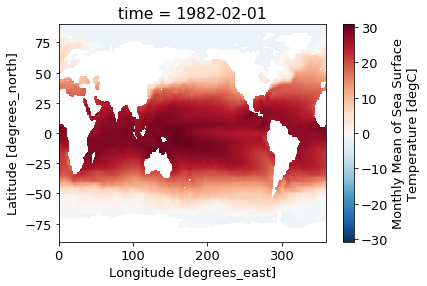

In [38]:
sst[2].plot()

In [39]:
## making longitude go from - 180 - 180 instead of 0 - 360
i = sst.lon
sst = xr.concat(
    [sst.sel(lon=i[(i >= 180)]), sst.sel(lon=i[(i < 180)])],
    dim="lon"
)
sst = sst.assign_coords({"lon": (((sst.lon + 180) % 360) - 180)})

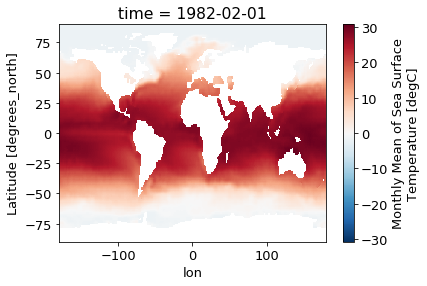

In [40]:
sst[2].plot()

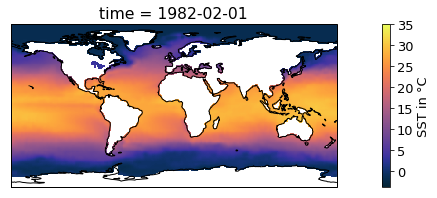

In [48]:
fig = plt.figure(figsize=(8,3))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.set_extent((-180, 180, -90, 90), crs=projection)
ax.coastlines()
x = sst.isel(time=2).plot.pcolormesh(ax=ax, add_colorbar=False, cmap = cmo.cm.thermal, vmin=-4, vmax=35)
cbar = plt.colorbar(x, fraction=.043, pad=0.1)
cbar.set_label('SST in °C')
plt.show()


In [49]:
## now isolating europe

#print(sst.lon[129:230])
#print(sst.lat[25:55])

sst_eu = sst[:, 18:60, 155:215]

lon_eu = sst.lon[155:215]
lat_eu = sst.lat[18:60]

In [50]:
#function to make maps so we don't need to keep loading everything all maps (:
def maps_europe(var,title,colorbounds1,colorbounds2,val):
    fig = plt.figure(figsize=(9,4))
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    ax.set_extent((-24, 34, 31, 71), crs=projection)
    ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
    ax.coastlines()
    x = ax.contourf(lon_eu,lat_eu,var, np.arange(colorbounds1,colorbounds2,val), cmap = cmo.cm.thermal)
    cbar = plt.colorbar(x, fraction=.043, pad=0.08)
    cbar.set_label("SST ($^\circ C$)", labelpad=-1)
    gridlines = ax.gridlines(draw_labels=True)
    #plot title
    ax.text(.5,1.15, title, va='top',ha='center', rotation='horizontal', rotation_mode= 'anchor',transform=ax.transAxes)
    plt.show()

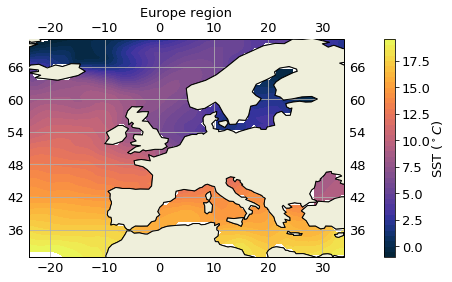

In [51]:
## just making sure we're looking at europe (ssts)

maps_europe(sst_eu[2],'Europe region',-1,20,.5)

In [52]:
#%% Part 1 
# Which location was warmest/coldest/hottest/driest within a three-month period? What
# country or ocean is at that location? At what time did the maximum (minimum) occur?

t_max = sst_eu.max(dim='time') #reduce time dimension and select maximum value over all timsteps at each gridpoint
t_min = sst_eu.min(dim='time')

t_max_lat = t_max.max(dim='lon').idxmax('lat').values.item() #reduce the longitude dimension and select the maximum for
# each gridpoint, then determine latitude value of the maximum along latitude with idxmax() function, extract corres-
# ponding Numpy array by appending .values and convert 1D array to float by appending .item()
t_max_lon = t_max.max(dim='lat').idxmax('lon').values.item() #same but for longitude
t_max_time = sst_eu.sel(lat=t_max_lat, lon=t_max_lon).idxmax('time').values # see http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sel.html#xarray.DataArray.sel
print('The maximum occured at lat ' + str(t_max_lat) + ' and lon ' + str(t_max_lon) + ' at on ' + str(t_max_time)[0:10])

#same for minimum
t_min_lat = t_min.min(dim='lon').idxmin('lat').values.item()
t_min_lon = t_min.min(dim='lat').idxmin('lon').values.item()
t_min_time = sst_eu.sel(lat=t_min_lat, lon=t_min_lon).idxmin('time').values #http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sel.html#xarray.DataArray.sel
print('The minimum occured at lat ' + str(t_min_lat) + ' and lon ' + str(t_min_lon) + ' at on ' + str(t_min_time)[0:10])


The maximum occured at lat 33.5 and lon 10.5 at on 2003-09-01
The minimum occured at lat 71.5 and lon -24.5 at on 1989-02-01


In [53]:
def maps_min_max_temp(var,title,T_longitude,T_latitude):
    fig = plt.figure(figsize=(9,4))
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    ax.set_extent((-24, 34, 31, 71), crs=projection)
    ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
    ax.coastlines()
    ## making colorbar min and max the same 
    x = ax.contourf(lon_eu,lat_eu,var, np.arange(-3.2,30,.5),cmap = cmo.cm.thermal) #np.arange(-4,26,2), extend='both'
    cbar = plt.colorbar(x, fraction=.043, pad=0.08)
    cbar.set_label("SST ($^\circ C$)", labelpad=-1)
    gridlines = ax.gridlines(draw_labels=True)
    plt.scatter(x=T_longitude, y=T_latitude, s=180, c='limegreen', marker='o')
    #plot title
    ax.text(.5,1.15, title, va='top',ha='center', rotation='horizontal', rotation_mode= 'anchor',transform=ax.transAxes)
    plt.show()

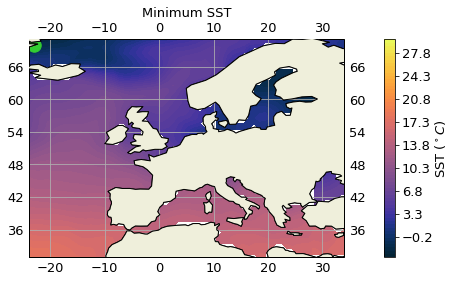

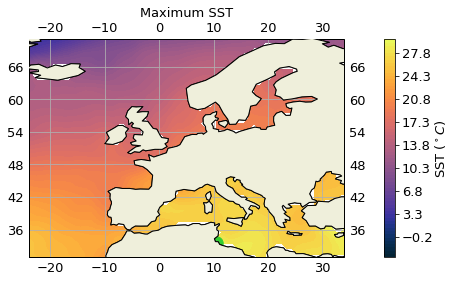

In [54]:
maps_min_max_temp(t_min,'Minimum SST',-23, 70)

maps_min_max_temp(t_max,'Maximum SST',t_max_lon, t_max_lat)

In [55]:
from textwrap import wrap

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


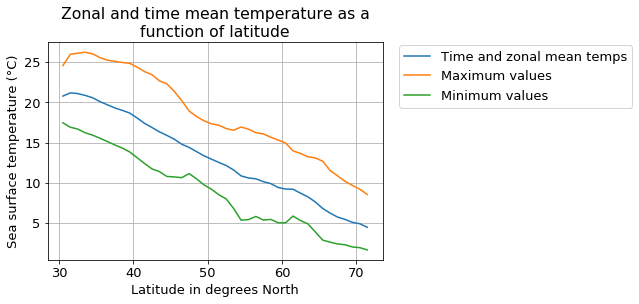

In [79]:
#%% Part 2
# Compute the monthly climatologies and anomalies with 'climanom.m' and the range of the mean seasonal cycle.

# see here: http://xarray.pydata.org/en/stable/time-series.html - "Resampling and grouped operations"
# monthly climatology:
sstemp_da_rm_climM = sst_eu.groupby('time.month').mean()
# monthly anomaly:
sstemp_da_rm_anomM = sst_eu.groupby('time.month') - sstemp_da_rm_climM #TODO not entirely sure this is the correct way.. needs some plausibility check of the results

# Plot the mean temperature (precipitation), averaged over all longitudes, as a function of latitude.
sstemp_da_rm_lat = sst_eu.mean(dim='lon').mean(dim='time')

fig2, ax2 = plt.subplots()
sstemp_da_rm_lat.plot(ax=ax2, label='Time and zonal mean temps')
sst_eu.max(dim='time').mean(dim='lon').plot(ax=ax2, label='Maximum values')
sst_eu.min(dim='time').mean(dim='lon').plot(ax=ax2, label='Minimum values')

ax2.set(xlabel='Latitude in degrees North', ylabel='Sea surface temperature (°C)', 
        title="\n".join(wrap('Zonal and time mean temperature as a function of latitude',40)))
ax2.grid()
ax2.legend(loc=(1.05,.7))
fig2.show()
#fig2.savefig('mean_t_lat.png', dpi=500)



In [84]:
sstemp_da_rm_climM.shape
#print(sstemp_da_rm_climM.max('month'))

#print(sstemp_da_rm_climM.min('month'))

(12, 42, 60)

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


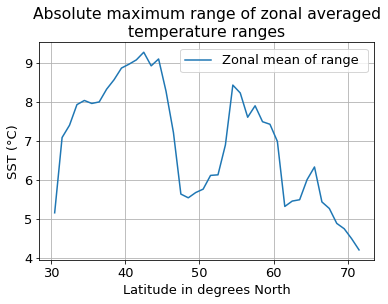

In [57]:
# Do the same for the range of the monthly climatologies.
sstemp_da_rm_ClimRange = (sstemp_da_rm_climM.max('month') - sstemp_da_rm_climM.min('month')).mean(dim='lon')

fig3, ax3 = plt.subplots()
sstemp_da_rm_ClimRange.plot(ax=ax3, label='Zonal mean of range ')
# airtemp_da_rm_lat.plot(ax=ax3, label='Time and zonal mean temperature')
ax3.set(xlabel='Latitude in degrees North', ylabel='SST (°C)', title="\n".join(wrap('Absolute maximum range of zonal averaged temperature ranges',40)))
ax3.grid()
ax3.legend(loc='upper right') #plt.legend(loc=(1.05,.55))
fig3.show()
#fig3.savefig('mean_range_lat.png', dpi=500)


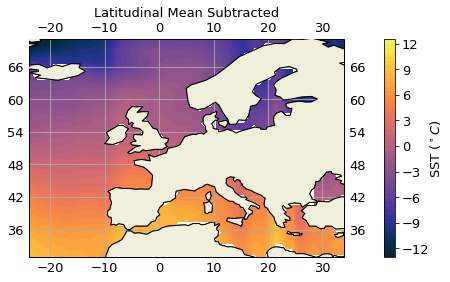

In [70]:
#subtract latitudinal means

lat_means_subtr = sst_eu.mean(dim='time') - sst_eu.mean(dim='time').mean(dim='lat') #originally was lon

maps_europe(lat_means_subtr,'Latitudinal Mean Subtracted',-13,13,.5)


/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


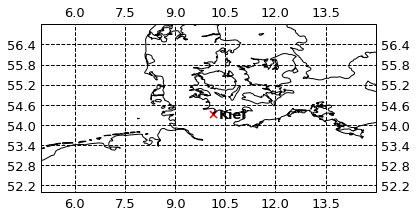

In [71]:
#%% Part 3
# Pick a location near Kiel. Alternatively, you can use a 2x2 box around Kiel and compute the average or use the MATLAB
# function 'interp2.m' to interpolate to Kiel. For the purpose of this exercise, all methods are fine but be aware that
# generally, interpolation in lat-lon coordinates should be weighted to take their true distances into account.

# we start by visualising the grid of the .nc file to better understand what interpolation/regridding is necessary, if any
fig5, ax5 = plt.subplots(subplot_kw={'projection' : ccrs.PlateCarree()})
gl = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=1, linestyle='--')
#gl.xlocator = mticker.FixedLocator(np.round(sst_eu.lon.values, 2))
#gl.ylocator = mticker.FixedLocator(np.round(sst_eu.lat.values, 2))
#ax5.contourf(lon_kiel,lat_kiel,sst_kiel[2], 50, cmap = 'RdBu_r')
ax5.coastlines(resolution='10m')
ax5.scatter(10.1228, 54.3233, s=50, marker='x', color='r')
ax5.set(ylabel='Latitude in deg North', xlabel='Longitude in deg East')#, title='Grid of source file')
ax5.set_extent([5,15,52,57])
ax5.annotate('Kiel', (.53,.44), xycoords='axes fraction', weight='bold')
fig5.show()

In [72]:
#print(sst_eu[:,16,35])

In [73]:
## using only one gridpoint for kiel... not the best resolution so hard to get exactly near kiel 

sst_kiel = sst_eu[:,16,35] #16:18, 33:37
lat_kiel = lat_eu[16]
lon_kiel = lon_eu[35]

#maps_test(sst_kiel[2],'sst kiel')

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


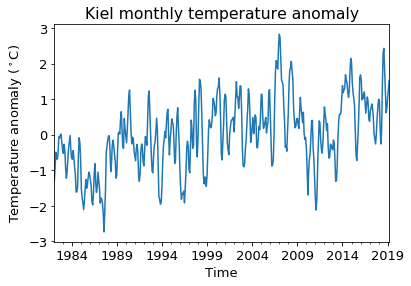

In [74]:
clim = sst_kiel.groupby('time.month').mean()
anom = sst_kiel.groupby('time.month') - clim

# we now look at a 1D timeseries at point lat,lon, hence we extract the data from the multidimensional data array
# into a pandas dataframe (with a datetime index for easy datetime functionality)
Kiel_anom = anom.to_dataframe().drop(labels=['lat','lon'], axis='columns').dropna() #also drop NaNs

#now we continue with this nice and clean 1D Pandas timeseries and plot for Kiel:
fig5, ax5 = plt.subplots()
Kiel_anom['sst'].plot(ax=ax5)
ax5.set(xlabel='Time', ylabel='Temperature anomaly ($^\circ$C)', title='Kiel monthly temperature anomaly')
fig5.show()

In [75]:
#%%
# Create a map of the trends using the function 'sigtrendmap.m'. Was there a significant trend anywhere else?
# If you are in the precipitation group, please use precipitable water. Feel free to follow 'example_3.m' to complete this task.

# http://atedstone.github.io/rate-of-change-maps/

arr = np.array(sst_eu) #dropna was not working for some reason, workaround is to convert the nans to zeros and then mask

# convert all nans to zeros and then remove zeros
where_are_NaNs = np.isnan(arr)
arr[where_are_NaNs] = 0

#mask all values where 0 is
sst_eu_mask = np.ma.masked_equal(arr,0) #instead of nans, now there is '--'

months = range(0, sst_eu_mask.shape[0])

vals2 = sst_eu_mask.reshape(len(months), -1)

regressions = np.polyfit(months, vals2, 1)

In [76]:
trends_month = regressions[0,:].reshape(sst_eu_mask.shape[1], sst_eu_mask.shape[2])
trends_year = trends_month * 12

# now rebuild an Xarray dataarray with the numpy array that contains the trends
trends_array = xr.DataArray(data=trends_year,
                            coords=[('lat',sst_eu.lat.values), ('lon',sst_eu.lon.values)],
                            name='Trends in sst',
                            attrs=dict(
                                description="Linear sst trends",
                                units="degC / year"
                            ))

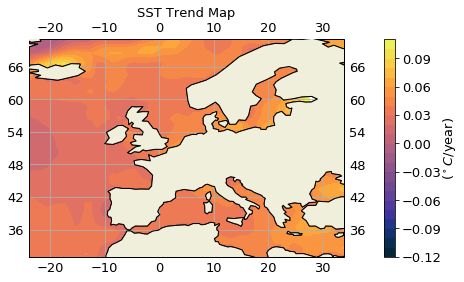

In [77]:
fig = plt.figure(figsize=(9,4))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.set_extent((-24, 34, 31, 71), crs=projection)
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
ax.coastlines()
x = ax.contourf(lon_eu,lat_eu,trends_array, np.arange(-.12,.12,.01), cmap = cmo.cm.thermal)
cbar = plt.colorbar(x, fraction=.043, pad=0.08)
cbar.set_label("($^\circ C$/year)", labelpad=-1) ## per year 
gridlines = ax.gridlines(draw_labels=True)
#plot title
ax.text(.5,1.15, 'SST Trend Map', va='top',ha='center', rotation='horizontal', rotation_mode= 'anchor',transform=ax.transAxes)
plt.show()